In [114]:
import pandas as pd 
import uproot as ur
import numpy as np
import awkward as ak
from sklearn.utils import shuffle


In [115]:
def root_to_pd(file_path, tree_name, branch_names):
    try:
        # Opening the ROOT file
        root_file = ur.open(file_path)
        print("Reading ROOT file")
        
        # Accessing the tree
        if tree_name not in root_file:
            print(f"Tree '{tree_name}' not found in the file!")
            return None
        
        root_tree = root_file[tree_name]
        
        # Reading branches into a dictionary of arrays
        branch_values = root_tree.arrays(branch_names, library="np")
        
        # Converting the dictionary of arrays to a DataFrame
        df = pd.DataFrame({name: branch_values[name] for name in branch_names})
        return df
    
    except FileNotFoundError:
        print("File not found!")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def read_fwd_pd(file_path):
    tree_name = "fwd"
    branch_names = ["fstHits.mXYZ.fX", "fstHits.mXYZ.fY", "fstHits.mXYZ.fZ", "mcTracks.mPxyz.mX1","mcTracks.mPxyz.mX2","mcTracks.mPxyz.mX3","mcTracks.mId","fstHits.mIdTruth", "seeds.mTrackId"]
    pd_frame = root_to_pd(file_path, tree_name, branch_names)
    
    if pd_frame is not None:
        pd_frame.rename(columns={
            "fstHits.mXYZ.fX": "fX",
            "fstHits.mXYZ.fY": "fY",
            "fstHits.mXYZ.fZ": "fZ",
            "reco.mIdTruth": "mIdTruth",
            "seeds.mTrackId":"trackID"
        }, inplace=True)
    
    return pd_frame

pd_frame = read_fwd_pd("fwdtree.root")

if pd_frame is not None:
    pd_frame.to_csv("data.csv")
else:
    print("Failed to read and process the ROOT file.")



Reading ROOT file


In [116]:
file = ur.open("fwdtree.root")
tree = file["fwd"]
branch_names = ["fstHits.mXYZ.fX", "fstHits.mXYZ.fY", "fstHits.mXYZ.fZ","mcTracks.mPxyz.mX1","mcTracks.mPxyz.mX2","mcTracks.mPxyz.mX3","mcTracks.mId","fstHits.mIdTruth"]

In [117]:
branches = tree.arrays(branch_names)
def read_tracks_from_branch(branch):
    track_list = []
    used_branch_id = []
    branch_ids = branch["fstHits.mIdTruth"]
    
    for branch_id in branch_ids:
        if branch_id not in used_branch_id:
            index_track = ak.where(branch_id == branch["fstHits.mIdTruth"])[0]  # Ensure the indices are flattened
            pos_x, pos_y, pos_z = [], [], []
            
            for index in index_track:
                pos_x.append(branch["fstHits.mXYZ.fX"][index])
                pos_y.append(branch["fstHits.mXYZ.fY"][index])
                pos_z.append(branch["fstHits.mXYZ.fZ"][index])
            
            combined = list(zip(pos_x, pos_y, pos_z))
            track_list.append(combined)
            used_branch_id.append(branch_id)
    
    return track_list

In [118]:
def read_tracks_from_branches(branches):
    all_tracks = []
    for branch in branches:
        branch_tracks = read_tracks_from_branch(branch)
        all_tracks.extend(branch_tracks)
    return all_tracks

def filter_tracks_by_length(tracks,valid_lengths=(2,3)):
    return [track for track in tracks if len(track) in valid_lengths]

def pad_track_list_by_nan(track_list):
    padded_tracks = []
    for hits in track_list:
        padding_num = 3 - len(hits)
        padded_hits = hits + [(np.nan, np.nan, np.nan)] * padding_num
        padded_tracks.append(padded_hits)
    return padded_tracks

def sort_subarrays_by_z(arr):
    sorted_arr = []
    for subarray in arr:
        nan_mask = np.isnan(subarray).all(axis=1)
        non_nan_entries = subarray[~nan_mask]
        nan_entries = subarray[nan_mask]
        sorted_non_nan_entries = non_nan_entries[non_nan_entries[:, 2].argsort()]
        sorted_subarray = np.vstack((sorted_non_nan_entries, nan_entries))
        sorted_arr.append(sorted_subarray)
    return np.array(sorted_arr)

def process_tracks(branches):
    # Read and combine tracks from all branches
    all_tracks = []
    for branch in branches:
        branch_tracks = read_tracks_from_branch(branch)
        all_tracks.extend(branch_tracks)

    # Filter tracks based on their length
    filtered_tracks = filter_tracks_by_length(all_tracks)

    # Pad the tracks
    padded_tracks = pad_track_list_by_nan(filtered_tracks)

    # Sort the subarrays by the z-coordinate
    sorted_tracks = sort_subarrays_by_z(np.array(padded_tracks))

    return np.array(sorted_tracks)
    

In [119]:
track_list = process_tracks(branches)

In [120]:
def append_true_track_feature(track_list):
    all_track = []
    for track in track_list:
        all_track.append(np.append(track,1))
    return np.array(all_track)

def make_fake_tracks_from_list(n,track_list,seed=0):
    fake_track_list = []
    random_min = 0
    random_max = len(track_list)
    np.random.seed(seed)
    while len(fake_track_list) < n:
        rng_track_indecies = np.random.randint(random_min,random_max,3)
        fake_layer_1 = track_list[rng_track_indecies[0]][0]
        fake_layer_2 = track_list[rng_track_indecies[1]][1]
        fake_layer_3 = track_list[rng_track_indecies[2]][2]
        fake_hit = np.concatenate((fake_layer_1,fake_layer_2,fake_layer_3),axis=0)  
        fake_track_list.append(np.append(fake_hit,0))
    return np.array(fake_track_list)

In [139]:
fake_track_list = make_fake_tracks_from_list(len(track_list),track_list)
mc_track_list = append_true_track_feature(track_list)
mc_and_fake_unshuffled = np.concatenate((fake_track_list,mc_track_list))
mc_and_fake_shuffled = shuffle(mc_and_fake_unshuffled)
training_frame = pd.DataFrame({'Truth':mc_and_fake_shuffled[:,-1],
                               'L1X':mc_and_fake_shuffled[:,0],'L1Y':mc_and_fake_shuffled[:,1],'L1Z':mc_and_fake_shuffled[:,2]
                               ,'L2X':mc_and_fake_shuffled[:,3],'L2Y':mc_and_fake_shuffled[:,4],'L2Z':mc_and_fake_shuffled[:,5]
                               ,'L3X':mc_and_fake_shuffled[:,6],'L3Y':mc_and_fake_shuffled[:,7],'L3Z':mc_and_fake_shuffled[:,8]
                               })
training_features = training_frame.drop("Truth",axis=1)
training_labels = training_frame["Truth"]

In [140]:
def linear_fit(row, col1, col2, col3):
    if pd.isna(row[col3]):
        return 2 * row[col2] - row[col1]
    return row[col3]

def linear_fit_implace(training_features):
    training_features['L3X'] = training_features.apply(lambda row: linear_fit(row, 'L1X','L2X','L3X'),axis=1)
    training_features['L3Y'] = training_features.apply(lambda row: linear_fit(row, 'L1Y','L2Y','L3Y'),axis=1)
    training_features['L3Z'] = training_features.apply(lambda row: linear_fit(row, 'L1Z','L2Z','L3Z'),axis=1)
    return training_features

training_features = linear_fit_implace(training_features)

# Cartesian XYZ

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = DecisionTreeClassifier(random_state=0,max_depth=50,min_samples_split=10,min_samples_leaf=10,max_features='log2')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9206161137440758


In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9680094786729858


In [167]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9478672985781991


In [170]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=1
)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9774881516587678


# Cartesian XY

In [172]:
track_list = process_tracks(branches)
fake_track_list = make_fake_tracks_from_list(len(track_list),track_list)
mc_track_list = append_true_track_feature(track_list)
mc_and_fake_unshuffled = np.concatenate((fake_track_list,mc_track_list))
mc_and_fake_shuffled = shuffle(mc_and_fake_unshuffled)
training_frame = pd.DataFrame({'Truth':mc_and_fake_shuffled[:,-1],
                               'L1X':mc_and_fake_shuffled[:,0],'L1Y':mc_and_fake_shuffled[:,1],'L1Z':mc_and_fake_shuffled[:,2]
                               ,'L2X':mc_and_fake_shuffled[:,3],'L2Y':mc_and_fake_shuffled[:,4],'L2Z':mc_and_fake_shuffled[:,5]
                               ,'L3X':mc_and_fake_shuffled[:,6],'L3Y':mc_and_fake_shuffled[:,7],'L3Z':mc_and_fake_shuffled[:,8]
                               })
training_features = training_frame.drop("Truth",axis=1)
training_labels = training_frame["Truth"]
training_features = linear_fit_implace(training_features)
training_features = training_features.drop(['L1Z','L2Z','L3Z'],axis=1)


In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = DecisionTreeClassifier(random_state=0,max_depth=50,min_samples_split=10,min_samples_leaf=10,max_features='log2')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9247630331753555


In [187]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9674170616113744


In [190]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9354265402843602


In [191]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=1
)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.966824644549763


# Polar

In [195]:
def cartesian_to_polar(row):
    R1 = np.sqrt(row['L1X']**2 + row['L1Y']**2)
    theta1 = np.arctan2(row['L1Y'],row['L1X'])
    R2 = np.sqrt(row['L2X']**2 + row['L2Y']**2)
    theta2 = np.arctan2(row['L2Y'],row['L2X'])
    R3 = np.sqrt(row['L3X']**2 + row['L3Y']**2)
    theta3 = np.arctan2(row['L3Y'],row['L3X'])
    return pd.Series([R1, theta1, R2, theta2, R3, theta3], index=['R1', 'theta1', 'R2', 'theta2', 'R3', 'theta3'])

track_list = process_tracks(branches)
fake_track_list = make_fake_tracks_from_list(len(track_list),track_list)
mc_track_list = append_true_track_feature(track_list)
mc_and_fake_unshuffled = np.concatenate((fake_track_list,mc_track_list))
mc_and_fake_shuffled = shuffle(mc_and_fake_unshuffled)
training_frame = pd.DataFrame({'Truth':mc_and_fake_shuffled[:,-1],
                               'L1X':mc_and_fake_shuffled[:,0],'L1Y':mc_and_fake_shuffled[:,1],'L1Z':mc_and_fake_shuffled[:,2]
                               ,'L2X':mc_and_fake_shuffled[:,3],'L2Y':mc_and_fake_shuffled[:,4],'L2Z':mc_and_fake_shuffled[:,5]
                               ,'L3X':mc_and_fake_shuffled[:,6],'L3Y':mc_and_fake_shuffled[:,7],'L3Z':mc_and_fake_shuffled[:,8]
                               })
training_features = training_frame.drop("Truth",axis=1)
training_labels = training_frame["Truth"]
training_features = linear_fit_implace(training_features)
training_features = training_features.drop(['L1Z','L2Z','L3Z'],axis=1)
training_features = training_features.apply(cartesian_to_polar, axis=1)

In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = DecisionTreeClassifier(random_state=0,max_depth=50,min_samples_split=10,min_samples_leaf=10,max_features='log2')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9152843601895735


In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9561611374407583


In [217]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9229857819905213


In [218]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=1
)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9614928909952607


# Cylindrical

In [226]:
track_list = process_tracks(branches)
fake_track_list = make_fake_tracks_from_list(len(track_list),track_list)
mc_track_list = append_true_track_feature(track_list)
mc_and_fake_unshuffled = np.concatenate((fake_track_list,mc_track_list))
mc_and_fake_shuffled = shuffle(mc_and_fake_unshuffled)
training_frame = pd.DataFrame({'Truth':mc_and_fake_shuffled[:,-1],
                               'L1X':mc_and_fake_shuffled[:,0],'L1Y':mc_and_fake_shuffled[:,1],'L1Z':mc_and_fake_shuffled[:,2]
                               ,'L2X':mc_and_fake_shuffled[:,3],'L2Y':mc_and_fake_shuffled[:,4],'L2Z':mc_and_fake_shuffled[:,5]
                               ,'L3X':mc_and_fake_shuffled[:,6],'L3Y':mc_and_fake_shuffled[:,7],'L3Z':mc_and_fake_shuffled[:,8]
                               })
training_features = training_frame.drop("Truth",axis=1)
training_labels = training_frame["Truth"]
training_features = linear_fit_implace(training_features)
def cartesian_to_polar(row):
    R1 = np.sqrt(row['L1X']**2 + row['L1Y']**2)
    theta1 = np.arctan2(row['L1Y'],row['L1X'])
    R2 = np.sqrt(row['L2X']**2 + row['L2Y']**2)
    theta2 = np.arctan2(row['L2Y'],row['L2X'])
    R3 = np.sqrt(row['L3X']**2 + row['L3Y']**2)
    theta3 = np.arctan2(row['L3Y'],row['L3X'])
    return pd.Series([R1, theta1, row['L1Z'], R2, theta2, row['L2Z'], R3, theta3, row['L3Z']], index=['R1', 'theta1','Z1', 'R2', 'theta2','Z2', 'R3', 'theta3','Z3'])
training_features = training_features.apply(cartesian_to_polar, axis=1)

,R1,theta1,Z1,R2,theta2,Z2,R3,theta3,Z3
0,23.687500,-1.417398,153.852905,26.562500,-1.417398,166.657104,26.5625,-1.417398,180.883911
1,15.062500,-0.190214,155.247925,6.437500,-2.345968,165.262085,9.3125,-0.574731,178.795044
2,12.187500,-1.364220,155.247925,9.312500,1.090149,168.745972,9.3125,-2.836842,178.795044
3,6.437500,-1.703741,151.764038,6.437500,-1.691469,168.745972,9.3125,-1.683288,178.795044
4,23.687499,-2.268246,153.852905,23.687499,-2.268246,166.657104,26.5625,-2.268246,180.883911


In [240]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = DecisionTreeClassifier(random_state=0,max_depth=50,min_samples_split=10,min_samples_leaf=10,max_features='log2')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9063981042654028


In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels)
clf = RandomForestClassifier()

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-4, verbose=0)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
tuned_rf_pred = best_rf_model.predict(X_test)
print("Tuned Random Forest Accuracy:", accuracy_score(y_test, tuned_rf_pred))
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, tuned_rf_pred))

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Random Forest Accuracy: 0.9721563981042654
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       858
         1.0       0.99      0.95      0.97       830

    accuracy                           0.97      1688
   macro avg       0.97      0.97      0.97      1688
weighted avg       0.97      0.97      0.97      1688



/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/100 - Train Accuracy: 0.6228 - Test Accuracy: 0.6121
Epoch 2/100 - Train Accuracy: 0.7908 - Test Accuracy: 0.7935
Epoch 3/100 - Train Accuracy: 0.8630 - Test Accuracy: 0.8727
Epoch 4/100 - Train Accuracy: 0.8819 - Test Accuracy: 0.8882
Epoch 5/100 - Train Accuracy: 0.8998 - Test Accuracy: 0.9082
Epoch 6/100 - Train Accuracy: 0.9115 - Test Accuracy: 0.9275
Epoch 7/100 - Train Accuracy: 0.9198 - Test Accuracy: 0.9356
Epoch 8/100 - Train Accuracy: 0.9291 - Test Accuracy: 0.9386
Epoch 9/100 - Train Accuracy: 0.9324 - Test Accuracy: 0.9460
Epoch 10/100 - Train Accuracy: 0.9372 - Test Accuracy: 0.9519
Epoch 11/100 - Train Accuracy: 0.9402 - Test Accuracy: 0.9541
Epoch 12/100 - Train Accuracy: 0.9417 - Test Accuracy: 0.9571
Epoch 13/100 - Train Accuracy: 0.9433 - Test Accuracy: 0.9571
Epoch 14/100 - Train Accuracy: 0.9450 - Test Accuracy: 0.9585
Epoch 15/100 - Train Accuracy: 0.9472 - Test Accuracy: 0.9600
Epoch 16/100 - Train Accuracy: 0.9496 - Test Accuracy: 0.9593
Epoch 17/100 - Tr

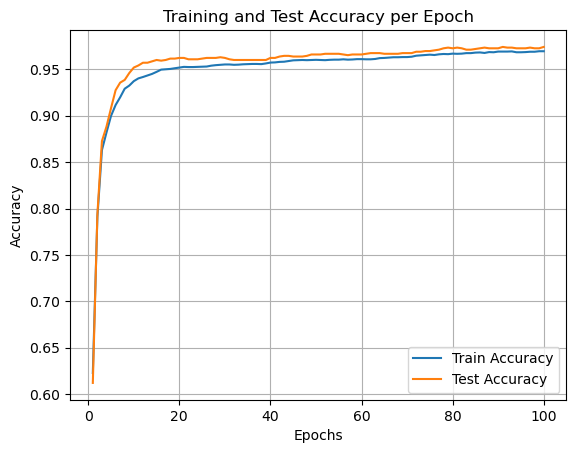

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=1)), 
    ('scaler', StandardScaler()),  # Standardize featuresA
])

# Transform the data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Initialize the MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(25, 25),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1,  # We will handle epochs manually
    warm_start=True,
    random_state=1
)

# Number of epochs
epochs = 100

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Custom training loop
for epoch in range(epochs):
    mlp.fit(X_train, y_train)
    train_pred = mlp.predict(X_train)
    test_pred = mlp.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch + 1}/{epochs} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}')

# Plotting the accuracies
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [254]:
from sklearn.model_selection import cross_val_score

# Define the pipeline without fitting
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),  # Adjust degree as needed
    ('scaler', StandardScaler()),  # Standardize features
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(25,25),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=1
    ))
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, training_features, training_labels, cv=5)

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}')


Cross-Validation Accuracy Scores: [0.97631384 0.96521095 0.95851852 0.96814815 0.97481481]
Mean Cross-Validation Accuracy: 0.97
